In [5]:
%matplotlib inline

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
sns.set_style('ticks')

Depenencies for using pyIDEAS/Biointense:
* Sympy
* Odespy ->  https://github.com/hplgit/odespy

In [7]:
# https://github.com/dfm/corner.py
import corner

In [8]:
import hydropy as hp

In [9]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16 

In [82]:
import pylab as p
p.rc('mathtext', default='it')

## Respirometer model in pyIDEAS

The following respirometric model  for aerobic degradation of acetate without biomass storage will be used (Gernaey, 2002). It predicts the model output variable exogenous oxygen uptake rate of bacteria: $OUR_{ex}$ ($mg L^{-1} d^{-1}$).

$$\frac{dS}{dt} = -(1-e^{-\frac{t}{\tau}})\mu_{max}\frac{1}{Y}\frac{S}{K_S + S}X$$
$$\frac{dX}{dt} = (1-e^{-\frac{t}{\tau}})\mu_{max}\frac{1}{Y}\frac{S}{K_S + S}X-bX$$
$$OUR_{ex} = (1-e^{-\frac{t}{\tau}})\mu_{max}\frac{1-Y}{Y}\frac{S}{S+k_S}X$$

with 

$S$: substrate concentration ($mgCOD\; L^{-1}$ ), <br>
$X$: biomass concentration ($mg COD\; L^{-1}$),<br>
$\tau$: retardation on biomass activity ($d^{-1}$ ), <br>
$Y$: yield of the biomass (-),<br>
$\mu_{max}$: maximum growth rate ($d^{-1}$), <br>
$K_s$: half-saturation Monod constant ($mg COD\; L^{-1}$) <br>
$\quad$(if $\mu$ equals half of $\mu_{max}$, the substrate $S$ equals $K_s$).

Reference: 

<small>Gernaey, K., Petersen, B., Nopens, I., Comeau Y. and P.A. Vanrolleghem, Modeling aerobic carbon source degradation processes using titrimetric data and combined respirometric-titrimetric data: experimental data and model structure, Biotechnology and bioengineering, 79(7), 741-753, 2002</small>

### Using the pyIDEAS modelling environment:

In [10]:
from biointense.model import Model
from biointense.measurements import ode_measurements
from biointense.optimisation import ParameterOptimisation
from biointense.sensitivity import NumericalLocalSensitivity
from biointense.confidence import BaseConfidence

We define the model equations and set up the model:

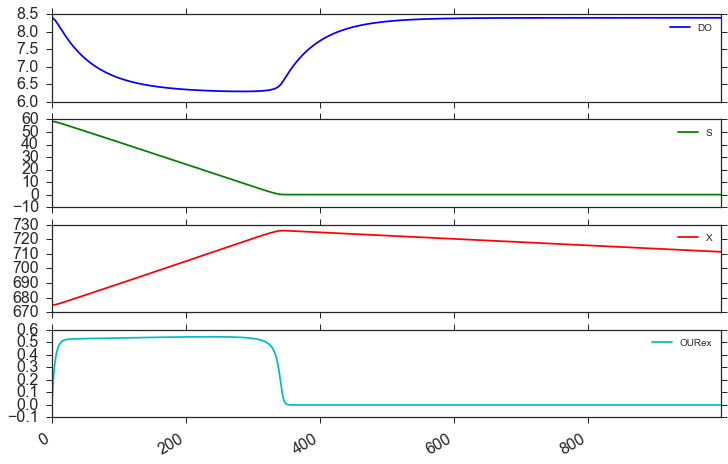

In [11]:
system = {'dS': '-(1. - exp(-t/tau))*(1/Y)*mu_max*S/(S+K_S)*X',
          'dX': '(1. - exp(-t/tau))*(1/Y)*mu_max*S/(S+K_S)*X - b*X',
          'dDO': '369.73*(8.4-DO)-((1-Y)/Y)*(1.0 - exp(-t/tau))*mu_max*S/(S+K_S)*X',
          'OURex': '((1.- exp(-t/tau))*mu_max*(1-Y)/Y*S/(S+K_S)*X)/(24.*60.)'}

parameters = {'mu_max': 4., 'K_S': 0.4, 'b': 0.62, 'Y': 0.78,
              'tau':2.25e-04}

timestepping = np.linspace(0, 0.05, 1000)
respiro_model = Model('Respirometry', system, parameters)
respiro_model.set_independent({'t': timestepping})
respiro_model.set_initial({'S': 58.48, 'X': 675, 'DO':8.4})

respiro_model.initialize_model()
output = respiro_model.run()
axs = output.plot(subplots=True, figsize=(12, 8))
output.index = timestepping

### Reading in the observations

### Cierkens et al

In [12]:
observations = pd.read_csv("respirometer_data.txt", sep="\t", index_col=0, 
                           names=["DO", "OURex"], skiprows=2)
observations.index = observations.index/(60*24)  #everything to days
observations.index.name='t'

In [13]:
observations.head()

,DO,OURex
t,,
0.000000,8.488234,0.006513
0.000010,8.488691,0.022208
0.000022,8.493058,0.037903
0.000035,8.495394,0.053598
0.000046,8.492392,0.069293


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f44d0926550>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f44d0840550>], dtype=object)

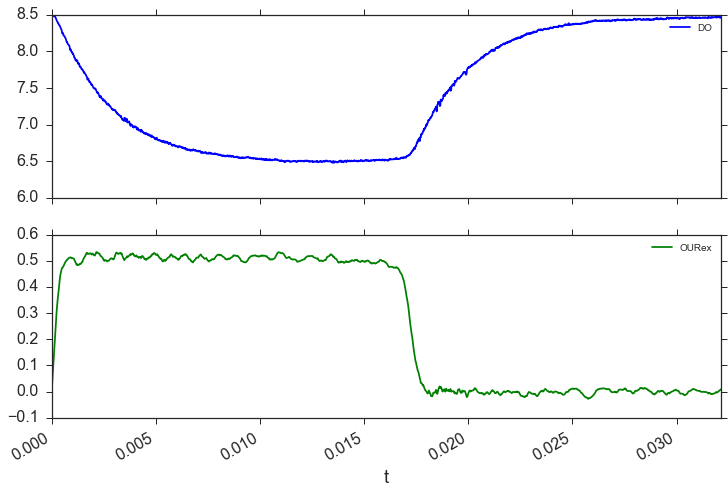

In [14]:
observations.plot(subplots=True, figsize=(12, 8))

In [25]:
0.015*24*60

21.599999999999998

In [15]:
(observations.index*24*60)[1300]

21.902864999999998

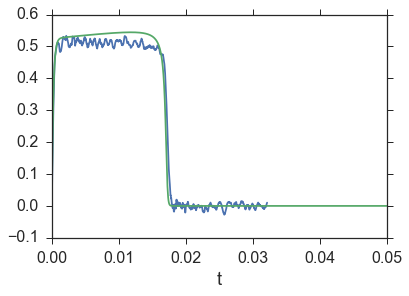

In [16]:
observations["OURex"].plot()
output["OURex"].plot()

### Decubber thesis

In [17]:
cubber_ref = pd.read_csv("../thesis_decubber/0508Aall_pieken.csv")[['NewTime','DO', 'OUR filt']]
cubber_ref = cubber_ref.set_index('NewTime')

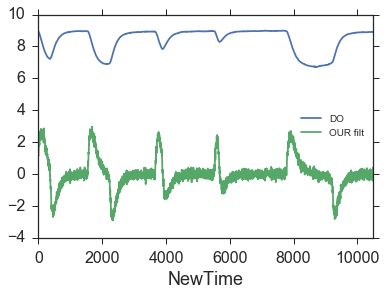

In [18]:
cubber_ref.plot()

In [19]:
cubber1 = pd.read_csv("../thesis_decubber/0508A1_pieken.csv")[['NewTime','DO', 'OUR filt']]
cubber1 = cubber1.set_index('NewTime')
cubber5 = pd.read_csv("../thesis_decubber/0508A5_pieken.csv")[['NewTime','DO', 'OUR filt']]
cubber5 = cubber5.set_index('NewTime')

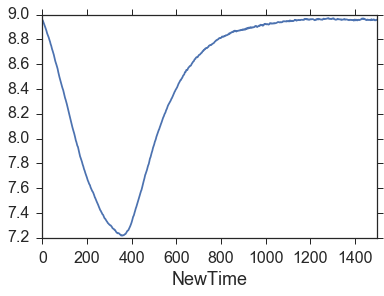

In [20]:
cubber1['DO'].plot()

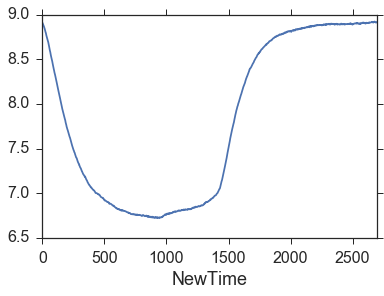

In [21]:
cubber5['DO'].plot()

So, we have three datasets to work with:
**observations, cubber1 and cubber5**

# INTERMEZZO - prepare runs brute/conservative MC

### mumax and tau

# MC Filtering as an explorative tool

### Checking behaviour of $\mu_{max}$ and K_S

In [23]:
def load_runs(ids=[4, 6], lengte=2745, N=30000):
    allruns = np.zeros((N*len(ids), lengte))
    allpars = np.zeros((N*len(ids), 2))
    allSSE = np.zeros(N*len(ids))
    for j,idrun in enumerate(ids):
        allruns[j*N:(j+1)*N, :] = np.fromfile('respiro_'+str(N) + 'runs_' +str(idrun) + '.txt').reshape(N, lengte)
        allpars[j*N:(j+1)*N, :] = np.fromfile('respiro_'+str(N) + 'pars_' +str(idrun) + '.txt').reshape(N, 2)
        allSSE[j*N:(j+1)*N] = np.fromfile('respiro_'+str(N) + 'SSE_' +str(idrun) + '.txt')
        
    return allruns, allpars, allSSE

In [ ]:
runs, pars, SSE = load_runs()

## MC filtering

In [ ]:
from plot_functions_rev import Scatter_hist_withOF
import matplotlib.cm as cm

combine some output runs

In [ ]:
treshold = 1.

In [ ]:
pars_behav = pars[SSE < treshold]
SSE_behav = SSE[SSE<treshold]

In [ ]:
fig, axScatter, axHistx, axHisty,sc1 = Scatter_hist_withOF(pars[:,0], pars[:,1], data1b=pars_behav[:,0], 
                                                           data2b=pars_behav[:,1], xbinwidth = 0.02, ybinwidth=0.05, 
                                                           relative = False, SSE=SSE, SSEb=SSE_behav, vmin=0.7, 
                                                           vmax=treshold*3, colormaps=cm.Greys_r, 
                                                           cleanstyle = True, 
                                                           roodlichter=0.5)
axScatter.set_xlabel(r'$\mu_{max}$',fontsize=16)
axScatter.set_ylabel(r'$K_S$',fontsize=16)
cbar = fig.colorbar(sc1, ax=axScatter, cmap='Greys', orientation='vertical',
                    ticks=[0.7, treshold, treshold*3], shrink=1.)
txts = cbar.ax.set_yticklabels(['0.7','<'+str(treshold),'> '+str(treshold*3)])
#plt.savefig('scatterhist1.pdf')
#plt.savefig('scatterhist1.png', dpi=300)

In [ ]:
fig, axScatter, axHistx, axHisty,sc1 = Scatter_hist_withOF(pars[:,0], pars[:,1], data1b=pars_behav[:,0], 
                                                           data2b=pars_behav[:,1], xbinwidth = 0.02, ybinwidth=0.05, 
                                                           relative = False, SSE=SSE, SSEb=SSE_behav, vmin=0.7, 
                                                           vmax=treshold, colormaps=cm.Greys_r, 
                                                           cleanstyle = True)
axScatter.set_xlabel(r'$\mu_{max}$',fontsize=16)
axScatter.set_ylabel(r'$K_S$',fontsize=16)
cbar = fig.colorbar(sc1, ax=axScatter, cmap='Greys', orientation='vertical',
                    ticks=[0.7, treshold], shrink=1.)
txts = cbar.ax.set_yticklabels(['0.7','<'+str(treshold)])
#plt.savefig('scatterhist2.pdf')
#plt.savefig('scatterhist2.png', dpi=300)

An alternative objective function

In [ ]:
def SSE_part(modelled, observed, slicet):
    residuals = modelled[:slicet] - observed[:slicet]   
    return sum(residuals**2)

In [ ]:
runs.shape

In [ ]:
sse_short = np.apply_along_axis(SSE_part, 1, runs, respiro_optim.measurements.Data["OURex"].values, 1300)

In [ ]:
plt.hist(sse_short)

In [ ]:
treshold_short=0.3
pars_behav_short = pars[sse_short < treshold_short]
SSE_behav_short = sse_short[sse_short<treshold_short]

In [ ]:
sse_short.max()

In [ ]:
SSE_behav_short.min()

In [ ]:
fig, axScatter, axHistx, axHisty,sc1 = Scatter_hist_withOF(pars[:,0], pars[:,1], xbinwidth = 0.02, ybinwidth=0.05, 
                                                           relative = False, SSE=sse_short, vmin=0.16, vmax=3.2, 
                                                           colormaps=cm.Greys_r, 
                                                           cleanstyle = True)
axScatter.set_xlabel(r'$\mu_{max}$',fontsize=16)
axScatter.set_ylabel(r'$K_S$',fontsize=16)
cbar = fig.colorbar(sc1, ax=axScatter, cmap='Greys', orientation='vertical', shrink=1.)
#txts = cbar.ax.set_yticklabels(['0.05', '<'+str(treshold_short)])
#plt.savefig('scatterhist_start.pdf')
#plt.savefig('scatterhist_start.png', dpi=300)

In [ ]:
fig, axScatter, axHistx, axHisty,sc1 = Scatter_hist_withOF(pars[:,0], pars[:,1], data1b=pars_behav_short[:,0], 
                                                           data2b=pars_behav_short[:,1], xbinwidth = 0.02, ybinwidth=0.05, 
                                                           relative = False, SSE=sse_short, SSEb=SSE_behav_short, 
                                                           vmin=0.16, vmax=0.32, colormaps=cm.Greys_r, 
                                                           cleanstyle = True)
axScatter.set_xlabel(r'$\mu_{max}$',fontsize=16)
axScatter.set_ylabel(r'$K_S$',fontsize=16)
cbar = fig.colorbar(sc1, ax=axScatter, cmap='Greys', orientation='vertical',
                    ticks=[0.16, treshold_short], shrink=1.)
txts = cbar.ax.set_yticklabels(['0.16', '<'+str(treshold_short)])
plt.savefig('scatterhist_start.pdf')
plt.savefig('scatterhist_start.png', dpi=300)

# Confronting the measurements and the model in the optimization class:

Focusing on the OUR measurements only:

In [65]:
respiro_data = ode_measurements(pd.DataFrame(observations["OURex"]))

Adding a relative measurement error for the measurements (based on the noise of the measurement):

In [66]:
respiro_data.add_measured_errors({'OURex': 0.01})

We assume that only the kinetic parameters are uncertain and need to be estimated:

In [67]:
respiro_optim = ParameterOptimisation(respiro_model, respiro_data, optim_par=['mu_max','K_S', 'tau'])

Running a local optimization (actually maximuma likelihood special case situation):

In [175]:
respiro_optim.local_optimize(pardict={'mu_max':3., 'K_S':0.6, 'tau': 2.26e-4}, obj_crit='wsse', method='Nelder-Mead')

  status: 0
    nfev: 462
 success: True
     fun: 12333014.088299507
       x: array([  3.91223097e+00,   3.30235455e-01,   2.59862865e-04])
 message: 'Optimization terminated successfully.'
     nit: 237

In [176]:
#mumax_es = np.random.uniform(1.0, 4., N)
#K_s_es = np.random.uniform(0.1, 0.8, N)

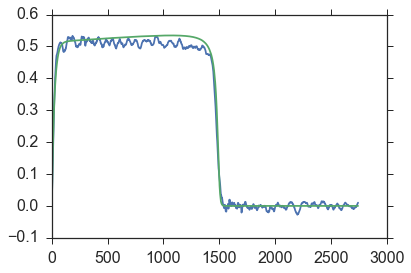

In [180]:
plt.plot(respiro_optim.modmeas["Measured"]["OURex"])
plt.plot(respiro_optim.modmeas["Modelled"]["OURex"])
respiro_optim.dof
myrun = respiro_optim._run_model(dof_array=np.array([3.9, 0.4]))

In [35]:
#myrun

### Exploration of using pyIDEAS in emcee Hammer: posterior of $\mu_{max}$ and $K_S$

http://dan.iel.fm/emcee/current/

In [52]:
import emcee

In [56]:
def respiro_get_residuals(parameters):
    """run respiromodel and calculate the residuals as a numpy.array
    """
    mu_max, K_S = parameters
    residuals = respiro_optim._run_model(dof_array=np.array([mu_max, K_S]))["OURex"] - \
                                respiro_optim.measurements.Data["OURex"]
    return residuals.values

In [57]:
respiro_get_residuals([3.9, 0.4])

array([-0.00651276,  0.00072707,  0.00955954, ..., -0.00864222,
       -0.00939906, -0.01015596])

In [58]:
def lnprior(parameters):
    mu_max, K_S = parameters
    if 3.5 < mu_max < 4.2 and 0.1 < K_S < 0.9:
        return 0.0
    return -np.inf

In [59]:
# gaussian, geen meetfout,...
def lnlike(parameters):
    residuals = respiro_get_residuals(parameters)
    observed = respiro_optim.measurements.Data["OURex"].values
    N = len(observed)
    sigma2 = np.std(observed)**2.
    loglike = -N*np.log(2*np.pi)/2. - N*np.log(sigma2)/2. - ((residuals)**2).sum()/(2*sigma2)
    return loglike

In [60]:
def lnprob(parameters):
    lp = lnprior(parameters)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(parameters)

In [42]:
ndim, nwalkers = 2, 100
pos = [[3.9, 0.32] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [43]:
respiro_optim.measurements.Data["OURex"].values

array([ 0.00651276,  0.02220774,  0.03790266, ...,  0.00864222,
        0.00939906,  0.01015596])

In [44]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
sampl_out = sampler.run_mcmc(pos, 500)

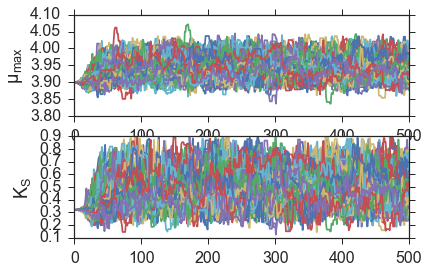

In [45]:
fig, ax = plt.subplots(2, 1)
for i in range(100):
    ax[0].plot(sampler.chain[i, :, 0])
    ax[1].plot(sampler.chain[i, :, 1])
ax[0].set_ylabel(r'$\mu_{max}$')
ax[1].set_ylabel(r'$K_S$')

In [46]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.723


In [47]:
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))

In [48]:
import corner

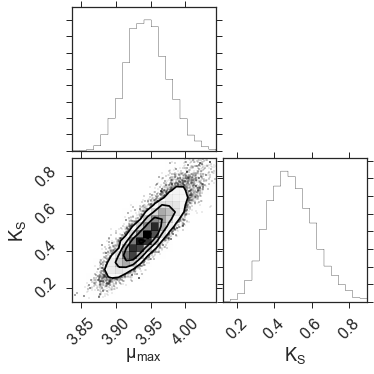

In [49]:
import corner
fig = corner.corner(samples, labels=["$\mu_{max}$", "$K_S$"],
                    quantiles=None, plot_contours=True)
fig.savefig('test.pdf')

In [ ]:
sampler.acor

In [ ]:
temp = fig.get_axes()[2]
xlims = temp.get_xlim()
ylims = temp.get_ylim()

In [ ]:
xlims, ylims

## Parameter estimation of the parameters $\mu_{max}$, $K_S$ and $\tau$

### Bayesian estimation of the parameter posterior distribution

Helper function to link the model and errors -> residuals

In [69]:
def respiro_get_residuals2(parameters):
    """run respiromodel and calculate the residuals as a numpy.array
    """
    mu_max, K_S, tau = parameters
    residuals = respiro_optim._run_model(dof_array=np.array([mu_max, K_S, tau]))["OURex"] - \
                                respiro_optim.measurements.Data["OURex"]
    return residuals.values

Assuming Gaussian errors, without any measurement error:

In [70]:
# gaussian, geen meetfout,...
def lnlike2(parameters):
    residuals = respiro_get_residuals2(parameters)
    observed = respiro_optim.measurements.Data["OURex"].values
    N = len(observed)
    sigma2 = np.std(observed)**2.
    loglike = -N*np.log(2*np.pi)/2. - N*np.log(sigma2)/2. - ((residuals)**2).sum()/(2*sigma2)
    return loglike

Uniform priors within specified regions:

In [71]:
def lnprior2(parameters):
    mu_max, K_S, tau = parameters
    if 3.5 < mu_max < 4.2 and 0.1 < K_S < 0.9 and 0.000226*0.5 < tau < 0.001*1.5:
        return 0.0
    return -np.inf

Combining the probabilities of the prior and the gaussian likihood function:

In [72]:
def lnprob2(parameters):
    lp = lnprior2(parameters)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike2(parameters)

Applying the emcee Hammer library to sample the posterior:

In [73]:
ndim, nwalkers = 3, 100
pos = [[3.9, 0.32, 2.25e-04] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [74]:
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, lnprob2)
sampl_out2 = sampler2.run_mcmc(pos, 500)

Check the different sampler chains:

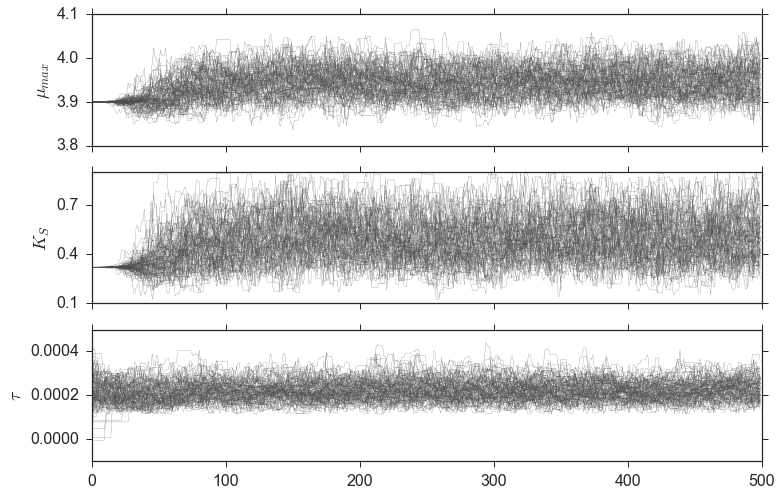

In [173]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
for i in range(100):
    ax[0].plot(sampler2.chain[i, :, 0], c='0.3', linewidth=0.2)
    ax[1].plot(sampler2.chain[i, :, 1], c='0.3', linewidth=0.2)
    ax[2].plot(sampler2.chain[i, :, 2], c='0.3', linewidth=0.2)
ax[0].set_ylabel(r'$\mu_{max}$')
ax[0].set_yticks([3.8, 3.9, 4., 4.1])
ax[1].set_ylabel(r'$K_S$')
ax[1].set_yticks([0.1, 0.4, 0.7])
ax[2].set_ylabel(r'$\tau$')
ax[2].set_yticks([-0.0, 0.0002, 0.0004])
plt.savefig("mcmc_samples.pdf")

In [77]:
samples = sampler2.chain[:, 200:, :].reshape((-1, ndim))

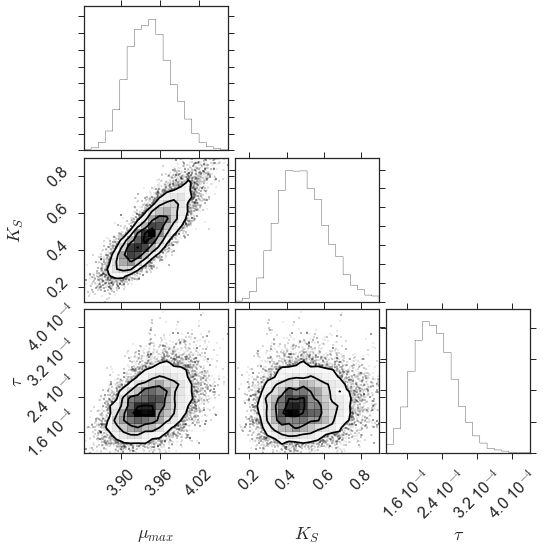

In [144]:
import corner
fig= corner.corner(samples, labels=["$\mu_{max}$", "$K_S$", r"$\tau$"],
                    quantiles=None, plot_contours=True)
#fig.savefig('test.pdf')
axs = fig.get_axes()
#axs[8].xaxis.get_major_formatter().set_powerlimits((0, 1))

scale_pow = 4
from matplotlib import ticker
from matplotlib.ticker import FuncFormatter

def my_formatter_fun(x, p):
    return "%.1f" % (x * (10 ** scale_pow)) + ' 10$^{{{0:d}}}$'.format((-1*scale_pow))
axs[6].get_yaxis().set_major_formatter(ticker.FuncFormatter(my_formatter_fun))
axs[8].get_xaxis().set_major_formatter(ticker.FuncFormatter(my_formatter_fun))

for ax in axs:
    ax.yaxis.set_label_coords(-0.4, 0.5)
    ax.xaxis.set_label_coords(0.5, -0.5)
    
for tick in axs[6].get_yaxis().get_major_ticks():
    tick.set_pad(-2)
    tick.label1 = tick._get_text1()
plt.setp(axs[6].yaxis.get_majorticklabels(), rotation=45 )

#axs[6].yaxis.get_major_formatter().set_scientific(True)

#axs[6].set_yticklabels(['1.6e$^{-4}$','2.4e$^{-4}$','3.2e$^{-4}$','4.0e$^{-4}$'])
plot_margin = 0.25

plt.savefig('mcmc_result_respirometry.pdf', bbox_inches='tight')

In [174]:
sampler2.acor

array([ 68.02049256,  66.92189665,  42.92611976])

### Maximum Likelihood estimation 

In [160]:
import scipy.optimize as op
nll = lambda *args: -lnlike2(*args)
result = op.minimize(nll, [3.9, 0.3, 2.25e-04], method='Nelder-Mead')
m_ml, b_ml, lnf_ml = result["x"]

In [161]:
result

  status: 0
    nfev: 97
 success: True
     fun: -1275.6599206349847
       x: array([  3.93672964e+00,   4.55131937e-01,   2.15231754e-04])
 message: 'Optimization terminated successfully.'
     nit: 52

In [162]:
m_ml, b_ml, lnf_ml 

(3.9367296379326135, 0.45513193684773456, 0.00021523175445251703)

This does indeed agree with the density regions found by the markov chain sampler

Check the resulting model calibration result:

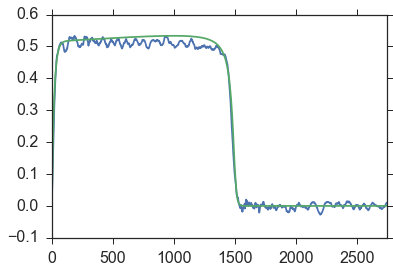

In [183]:
plt.plot(respiro_optim.modmeas["Measured"]["OURex"])
myrun = respiro_optim._run_model(dof_array=np.array([3.93, 0.45, 0.000215]))
myrun.OURex.plot()